# Notebook to plot results from deblurring

## Less blurry patches

[INFO] Image+CLIP: found 192 metrics files
[INFO] Image-only: found 192 metrics files
[INFO] Random init: found 192 metrics files
[INFO] Loaded 1152 PSNR points total
[INFO] Datatypes: ['amyloid_plaque_patches', 'c_fos_positive_patches', 'cell_nucleus_patches', 'vessels_patches']


,series,subtype,train_size,metric,csv_path
0,Image+CLIP,amyloid_plaque_patches,10,19.1584,/midtier/paetzollab/scratch/ads4015/temp_selma...
1,Image+CLIP,amyloid_plaque_patches,10,30.3847,/midtier/paetzollab/scratch/ads4015/temp_selma...
2,Image+CLIP,amyloid_plaque_patches,11,31.3671,/midtier/paetzollab/scratch/ads4015/temp_selma...
3,Image+CLIP,amyloid_plaque_patches,11,19.3085,/midtier/paetzollab/scratch/ads4015/temp_selma...
4,Image+CLIP,amyloid_plaque_patches,12,18.1466,/midtier/paetzollab/scratch/ads4015/temp_selma...


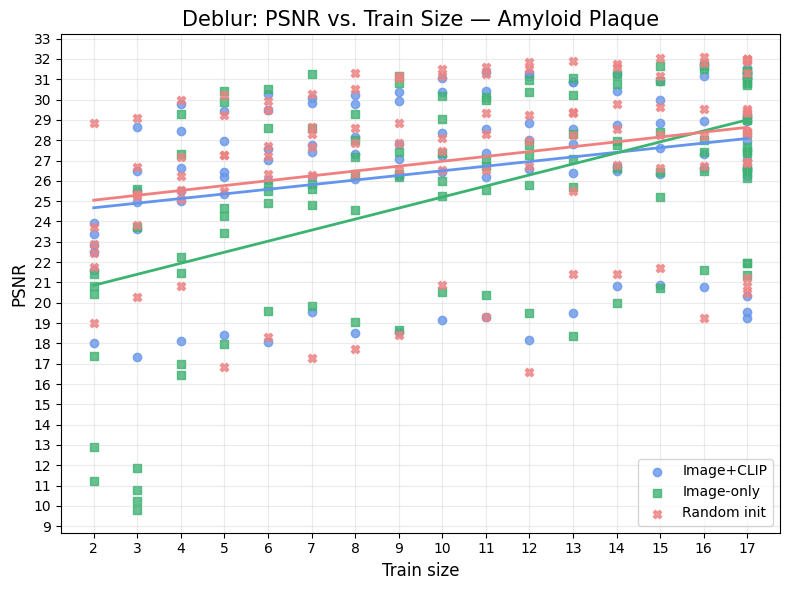

/tmp/ipykernel_1067508/2927369939.py:147: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x, y, 1)
/tmp/ipykernel_1067508/2927369939.py:147: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x, y, 1)
/tmp/ipykernel_1067508/2927369939.py:147: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x, y, 1)


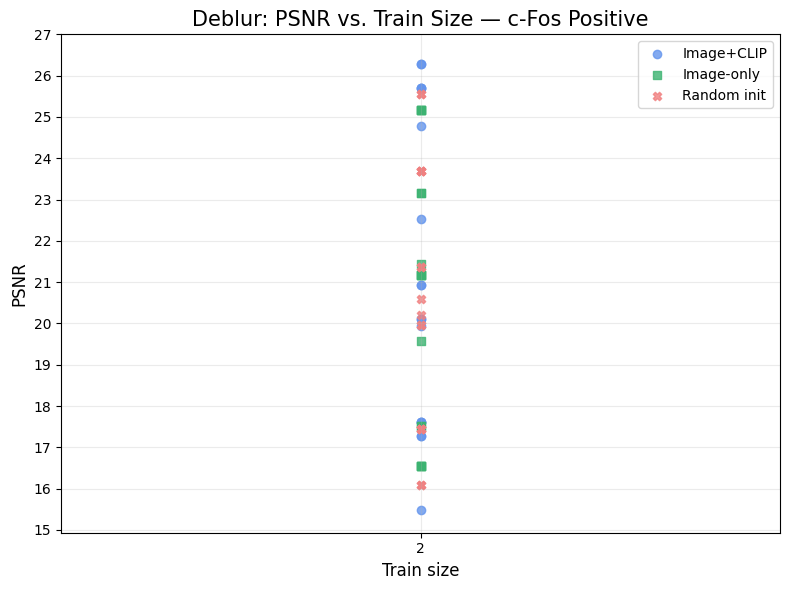

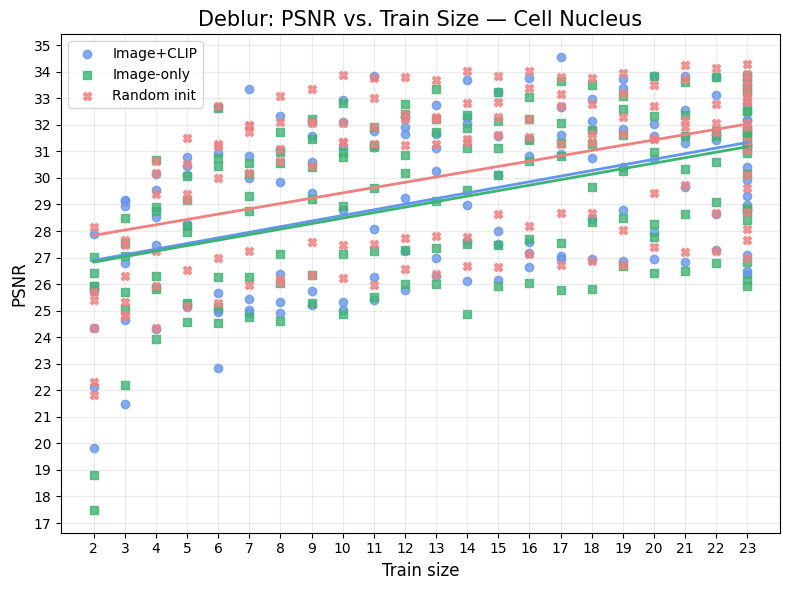

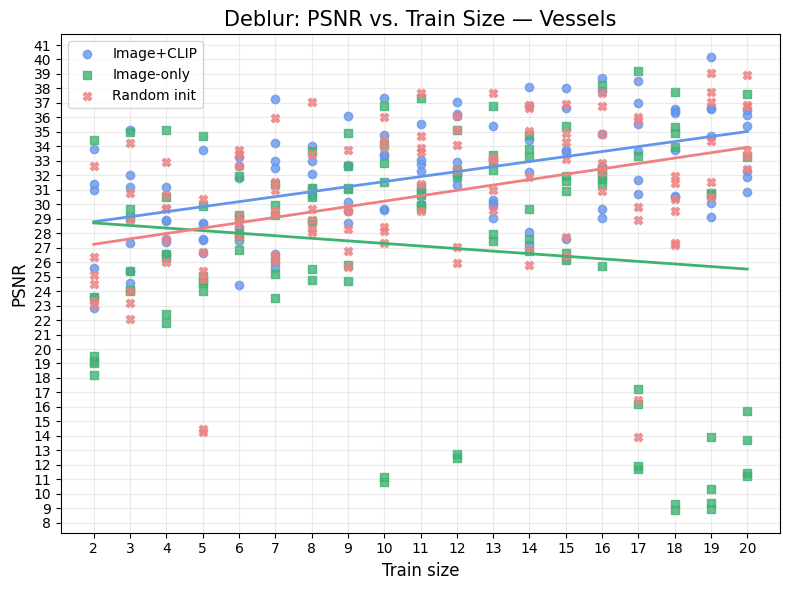

In [1]:
# ============================================================
# UPDATED DEBLURRING PSNR PLOTTING (x-axis = fttr + ftval)
# ============================================================

import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. CONFIGURATION
# --------------------------------------------------

RESULT_SETS = [
    ("Image+CLIP", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_autumn_sweep_27/preds"),
    ("Image-only", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_expert_sweep_31/preds"),
    ("Random init", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_random/preds"),
]

METRIC_COL = "psnr"

COLOR_MAP = {
    "Image+CLIP": "cornflowerblue",
    "Image-only": "mediumseagreen",
    "Random init": "lightcoral",
}

MARKER_MAP = {
    "Image+CLIP": "o",
    "Image-only": "s",
    "Random init": "X",
}

# Pretty names
PRETTY_NAME = {
    "amyloid_plaque_patches": "Amyloid Plaque",
    "c_fos_positive_patches": "c-Fos Positive",
    "cell_nucleus_patches": "Cell Nucleus",
    "vessels_patches": "Vessels",
}


# --------------------------------------------------
# 2. LOAD DATA FROM ALL metrics_test.csv FILES
# --------------------------------------------------

rows = []

for label, root in RESULT_SETS:
    root = Path(root)

    if not root.exists():
        print(f"[WARN] Skipping missing path: {root}")
        continue

    csv_paths = sorted(root.rglob("metrics_test.csv"))
    print(f"[INFO] {label}: found {len(csv_paths)} metrics files")

    for csv_path in csv_paths:

        folder = str(csv_path)

        # -----------------------------
        # Extract fttr and ftval from folder name
        # -----------------------------
        m1 = re.search(r"fttr(\d+)", folder)
        m2 = re.search(r"ftval(\d+)", folder)

        if not (m1 and m2):
            print(f"[WARN] Missing fttr/ftval in path: {csv_path}")
            continue

        fttr = int(m1.group(1))
        ftval = int(m2.group(1))

        train_size = fttr + ftval   # NEW

        # -----------------------------
        # Extract subtype (datatype)
        # -----------------------------
        parts = csv_path.parts
        try:
            idx = parts.index("preds")
            subtype = parts[idx + 1]
        except ValueError:
            subtype = "unknown"

        # -----------------------------
        # Load metrics
        # -----------------------------
        df = pd.read_csv(csv_path)
        if METRIC_COL not in df.columns:
            print(f"[WARN] PSNR missing in {csv_path}")
            continue

        # Append ALL individual test results
        for psnr in df[METRIC_COL].astype(float):
            rows.append({
                "series": label,
                "subtype": subtype,
                "train_size": train_size,
                "metric": float(psnr),
                "csv_path": str(csv_path),
            })

data = pd.DataFrame(rows)
print(f"[INFO] Loaded {len(data)} PSNR points total")
print("[INFO] Datatypes:", sorted(data["subtype"].unique()))
display(data.head())


# --------------------------------------------------
# 3. PLOT PER DATATYPE
# --------------------------------------------------

for subtype in sorted(data["subtype"].unique()):

    sub_df = data[data["subtype"] == subtype].copy()
    if sub_df.empty:
        continue

    pretty = PRETTY_NAME.get(subtype, subtype.replace("_", " ").title())

    plt.figure(figsize=(8, 6))

    # -----------------------------
    # PLOT ALL SERIES
    # -----------------------------
    for series in sub_df["series"].unique():
        df_s = sub_df[sub_df["series"] == series]

        # scatter all test points (6 per train size)
        plt.scatter(
            df_s["train_size"],
            df_s["metric"],
            color=COLOR_MAP[series],
            marker=MARKER_MAP[series],
            alpha=0.8,
            label=series
        )

        # best-fit line
        x = df_s["train_size"].values
        y = df_s["metric"].values
        if len(df_s) > 1:
            a, b = np.polyfit(x, y, 1)
            xs = np.linspace(min(x), max(x), 200)
            ys = a * xs + b
            plt.plot(xs, ys, color=COLOR_MAP[series], linewidth=2)

    # -----------------------------
    # Axis formatting
    # -----------------------------

    # X axis = every integer
    xmin, xmax = sub_df["train_size"].min(), sub_df["train_size"].max()
    plt.xticks(np.arange(xmin, xmax + 1, 1))

    # Y axis = every integer
    ymin, ymax = sub_df["metric"].min(), sub_df["metric"].max()
    ymin_i = int(np.floor(ymin))
    ymax_i = int(np.ceil(ymax))
    plt.yticks(np.arange(ymin_i, ymax_i + 1, 1))

    plt.xlabel("Train size", fontsize=12)
    plt.ylabel("PSNR", fontsize=12)
    plt.title(f"Deblur: PSNR vs. Train Size — {pretty}", fontsize=15)

    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Blurrier patches

[INFO] Image+CLIP: found 192 metrics files
[INFO] Image-only: found 192 metrics files
[INFO] Random init: found 192 metrics files
[INFO] Loaded 1152 PSNR points total
[INFO] Datatypes: ['amyloid_plaque_patches', 'c_fos_positive_patches', 'cell_nucleus_patches', 'vessels_patches']


,series,subtype,train_size,metric,csv_path
0,Image+CLIP,amyloid_plaque_patches,10,18.6191,/midtier/paetzollab/scratch/ads4015/temp_selma...
1,Image+CLIP,amyloid_plaque_patches,10,28.0971,/midtier/paetzollab/scratch/ads4015/temp_selma...
2,Image+CLIP,amyloid_plaque_patches,11,27.9858,/midtier/paetzollab/scratch/ads4015/temp_selma...
3,Image+CLIP,amyloid_plaque_patches,11,19.1165,/midtier/paetzollab/scratch/ads4015/temp_selma...
4,Image+CLIP,amyloid_plaque_patches,12,18.6397,/midtier/paetzollab/scratch/ads4015/temp_selma...


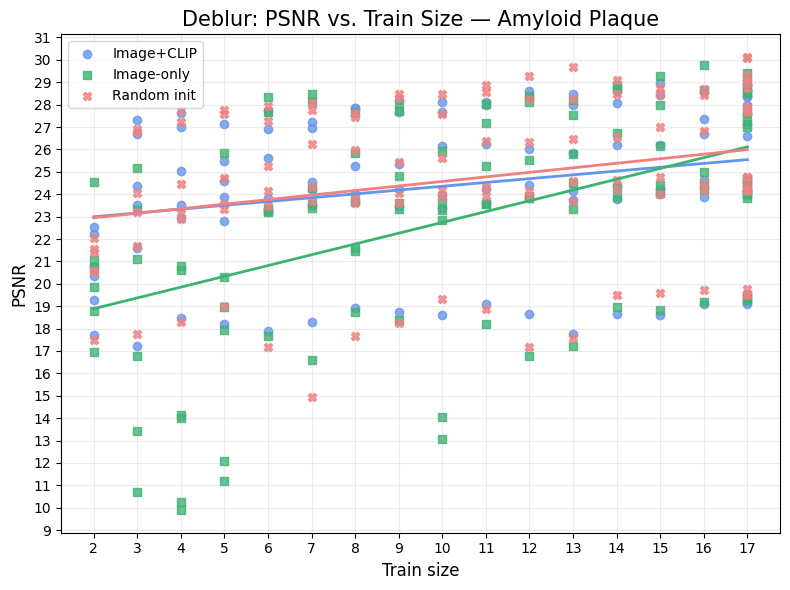

/tmp/ipykernel_1067508/4144131057.py:147: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x, y, 1)
/tmp/ipykernel_1067508/4144131057.py:147: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x, y, 1)
/tmp/ipykernel_1067508/4144131057.py:147: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x, y, 1)


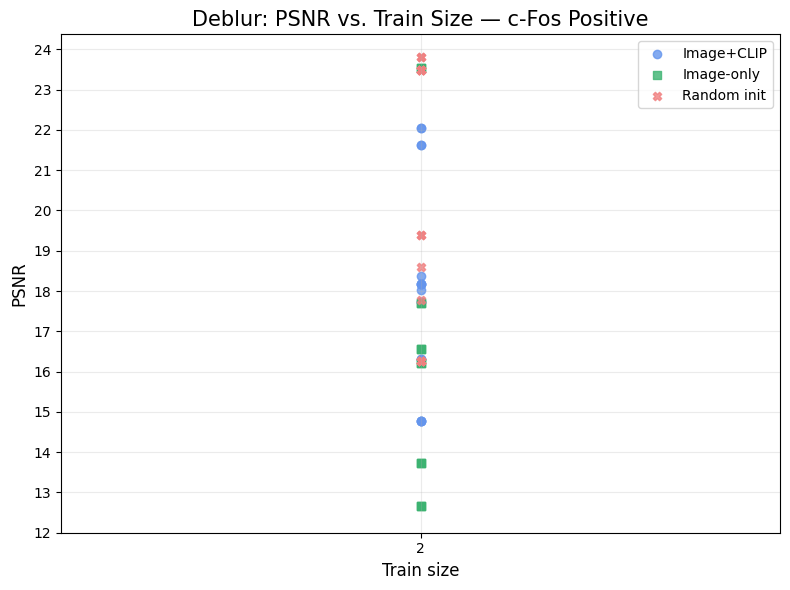

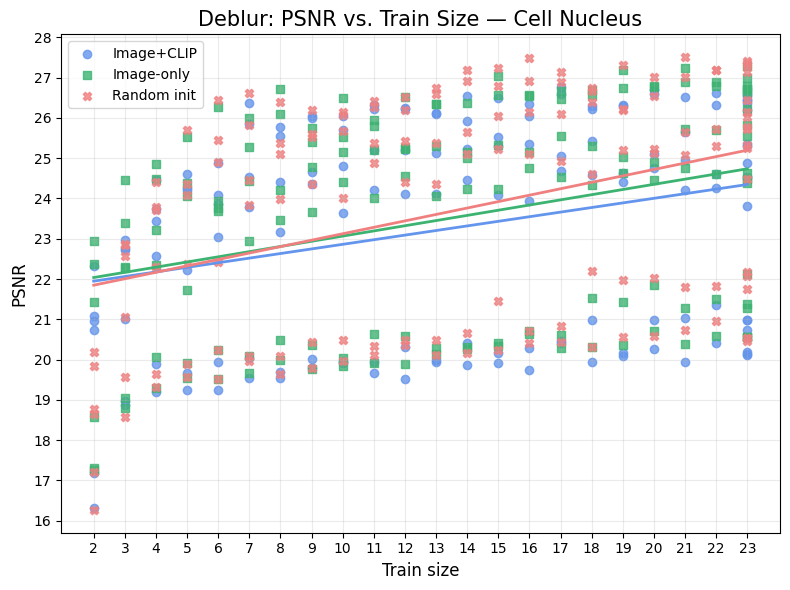

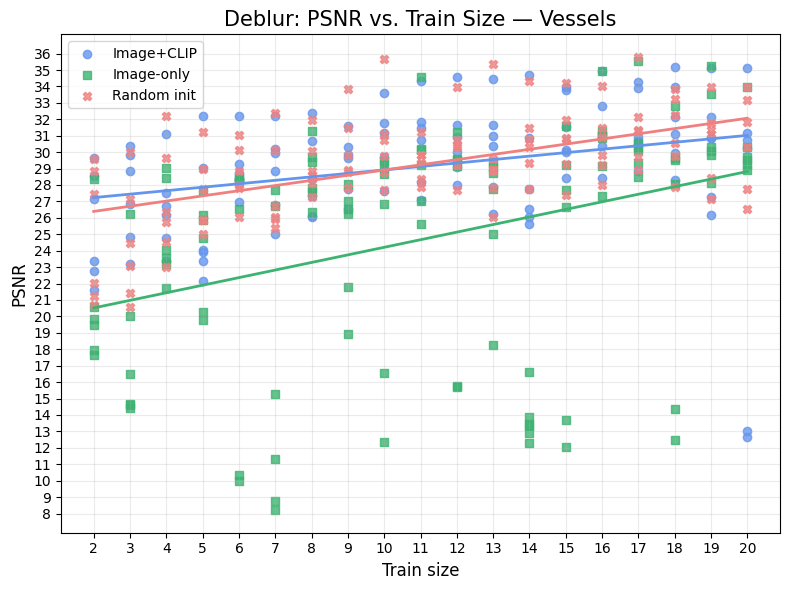

In [3]:
# ============================================================
# UPDATED DEBLURRING PSNR PLOTTING (x-axis = fttr + ftval)
# ============================================================

import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. CONFIGURATION
# --------------------------------------------------

RESULT_SETS = [
    ("Image+CLIP", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_autumn_sweep_27_v2/preds"),
    ("Image-only", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_expert_sweep_31_v2/preds"),
    ("Random init", "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_random_v2/preds"),
]

METRIC_COL = "psnr"

COLOR_MAP = {
    "Image+CLIP": "cornflowerblue",
    "Image-only": "mediumseagreen",
    "Random init": "lightcoral",
}

MARKER_MAP = {
    "Image+CLIP": "o",
    "Image-only": "s",
    "Random init": "X",
}

# Pretty names
PRETTY_NAME = {
    "amyloid_plaque_patches": "Amyloid Plaque",
    "c_fos_positive_patches": "c-Fos Positive",
    "cell_nucleus_patches": "Cell Nucleus",
    "vessels_patches": "Vessels",
}


# --------------------------------------------------
# 2. LOAD DATA FROM ALL metrics_test.csv FILES
# --------------------------------------------------

rows = []

for label, root in RESULT_SETS:
    root = Path(root)

    if not root.exists():
        print(f"[WARN] Skipping missing path: {root}")
        continue

    csv_paths = sorted(root.rglob("metrics_test.csv"))
    print(f"[INFO] {label}: found {len(csv_paths)} metrics files")

    for csv_path in csv_paths:

        folder = str(csv_path)

        # -----------------------------
        # Extract fttr and ftval from folder name
        # -----------------------------
        m1 = re.search(r"fttr(\d+)", folder)
        m2 = re.search(r"ftval(\d+)", folder)

        if not (m1 and m2):
            print(f"[WARN] Missing fttr/ftval in path: {csv_path}")
            continue

        fttr = int(m1.group(1))
        ftval = int(m2.group(1))

        train_size = fttr + ftval   # NEW

        # -----------------------------
        # Extract subtype (datatype)
        # -----------------------------
        parts = csv_path.parts
        try:
            idx = parts.index("preds")
            subtype = parts[idx + 1]
        except ValueError:
            subtype = "unknown"

        # -----------------------------
        # Load metrics
        # -----------------------------
        df = pd.read_csv(csv_path)
        if METRIC_COL not in df.columns:
            print(f"[WARN] PSNR missing in {csv_path}")
            continue

        # Append ALL individual test results
        for psnr in df[METRIC_COL].astype(float):
            rows.append({
                "series": label,
                "subtype": subtype,
                "train_size": train_size,
                "metric": float(psnr),
                "csv_path": str(csv_path),
            })

data = pd.DataFrame(rows)
print(f"[INFO] Loaded {len(data)} PSNR points total")
print("[INFO] Datatypes:", sorted(data["subtype"].unique()))
display(data.head())


# --------------------------------------------------
# 3. PLOT PER DATATYPE
# --------------------------------------------------

for subtype in sorted(data["subtype"].unique()):

    sub_df = data[data["subtype"] == subtype].copy()
    if sub_df.empty:
        continue

    pretty = PRETTY_NAME.get(subtype, subtype.replace("_", " ").title())

    plt.figure(figsize=(8, 6))

    # -----------------------------
    # PLOT ALL SERIES
    # -----------------------------
    for series in sub_df["series"].unique():
        df_s = sub_df[sub_df["series"] == series]

        # scatter all test points (6 per train size)
        plt.scatter(
            df_s["train_size"],
            df_s["metric"],
            color=COLOR_MAP[series],
            marker=MARKER_MAP[series],
            alpha=0.8,
            label=series
        )

        # best-fit line
        x = df_s["train_size"].values
        y = df_s["metric"].values
        if len(df_s) > 1:
            a, b = np.polyfit(x, y, 1)
            xs = np.linspace(min(x), max(x), 200)
            ys = a * xs + b
            plt.plot(xs, ys, color=COLOR_MAP[series], linewidth=2)

    # -----------------------------
    # Axis formatting
    # -----------------------------

    # X axis = every integer
    xmin, xmax = sub_df["train_size"].min(), sub_df["train_size"].max()
    plt.xticks(np.arange(xmin, xmax + 1, 1))

    # Y axis = every integer
    ymin, ymax = sub_df["metric"].min(), sub_df["metric"].max()
    ymin_i = int(np.floor(ymin))
    ymax_i = int(np.ceil(ymax))
    plt.yticks(np.arange(ymin_i, ymax_i + 1, 1))

    plt.xlabel("Train size", fontsize=12)
    plt.ylabel("PSNR", fontsize=12)
    plt.title(f"Deblur: PSNR vs. Train Size — {pretty}", fontsize=15)

    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()
